In [17]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

C:\Users\assay\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# 법령 XML 상세조회 (시행기준. target=eflaw)

#기본 url
url_base = " http://www.law.go.kr/DRF/lawService.do"

#조회 url 세부 설정
user_id = 'bmsong' #open API ID (bmsong@kau.ac.kr의 아이디 부분)
target = "eflaw" #법령 조회시
MST = "218289" #ID 또는 MST #산업안전보건법 MST 218289
#ID = "001766" 
            #ID 산업안전보건법 법령ID 001766 (설명에는 ID로 조회하면 현행법령이 조회된다는데, 
            #target을 eflaw로 하면 ID로 요청해도, MST로 요청해도 같은 것 같다.
Type = "XML" #출력 형태 : HTML 또는 XML

url_sub = "?" +\
        "OC=" + user_id +\
        "&target=" + target +\
        "&MST=" + MST +\
        "&type=" + Type

#최종 url
url = url_base + url_sub

print(url)

response = requests.get(url)

#(1) response.text 사용하는 방법
#soup = BeautifulSoup(response.text.encode('utf-8'), 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)

#(2) response.content 사용하는 방법
soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)


# soup

 http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=eflaw&MST=218289&type=XML


In [12]:
data = soup.find_all('조문단위')
df_info = pd.DataFrame()
info = []
jo_key = []
for i in data:
    info_str = ""
    if i.find("조문여부").get_text() == "조문":
        info_str += i.조문내용.get_text().strip()
        
        key = i['조문키']
        jo_key.append(key)
        
        
        if i.항:
            hang_nums = i.find_all("항번호")
            ho_nums = i.find_all("호번호")
            for idx, p in enumerate(i.find_all("호내용")):
                info_str += p.get_text().split(ho_nums[idx].get_text())[1].strip()
            for hang_idx, k in enumerate(i.find_all("항내용")):
                info_str += k.get_text().strip().split(hang_nums[hang_idx].get_text())[1].strip()
                for ho_idx ,j in enumerate(i.find_all("호내용")):
                    info_str += j.get_text().strip().split(ho_nums[ho_idx].get_text())[1].strip()
        info.append(info_str)
df_info['id'] = jo_key
df_info["조내용"] = info
df_info

,id,조내용
0,0001001,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1,0002001,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2,0003001,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업..."
3,0004001,제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4,0005001,제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
...,...,...
172,0171001,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173,0172001,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174,0173001,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ..."
175,0174001,제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...


In [15]:
stop_words = pd.read_excel("stopwords.xlsx")
stop_words

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
670,일곱
671,여덟
672,아홉
673,령


In [22]:
okt = Okt()
tokenized_data = []
for sentence in df_info['조내용']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stop_words and len(word) > 1] # 불용어 제거
    tokenized_data.append(temp_X)

조문의 최대 길이 : 6890
조문의 평균 길이 : 215.8135593220339


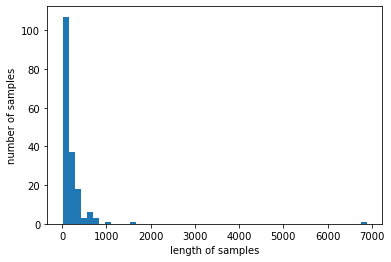

In [26]:
print('조문의 최대 길이 :',max(len(l) for l in tokenized_data))
print('조문의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
df_info['Token'] = tokenized_data
df_info

,id,조내용,Token
0,0001001,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...,"[1조, 목적, 산업, 안전, 보건, 기준, 확립, 하고, 책임, 소재, 명확하다,..."
1,0002001,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...,"[2조, 정의, 에서, 사용, 하다, 용어, 다음, 같다, 개정, 2020.5, 2..."
2,0003001,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...","[3조, 적용, 범위, 모든, 사업, 적용, 하다, 다만, 유해, 위험, 정도, 사..."
3,0004001,제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...,"[4조, 정부, 책무, 산업, 안전, 보건, 정책, 수립, 집행, 산업, 재해, 예..."
4,0005001,제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...,"[5조, 업주, 의무, 따르다, 명령, 으로, 하다, 산업, 재해, 예방, 기준, ..."
...,...,...,...
172,0171001,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...,"[171조, 벌칙, 다음, 호의, 어느, 하나, 해당, 하다, 자다, 1천만원, 이..."
173,0172001,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...,"[172조, 벌칙, 64조, 또는, 위반, 자다, 500만원, 이하, 벌금, 하다]"
174,0173001,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...","[173조, 규정, 법인, 대표자, 법인, 또는, 개인, 대리인, 사용, 종업원, ..."
175,0174001,제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...,"[174조, 형벌, 수강, 명령, 병과, 안전, 보건, 교육, 밖에, 산업, 재해,..."


In [28]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, window = 5, min_count = 5, workers = 4, sg = 0)

In [29]:
model.wv.vectors.shape

(744, 100)

In [32]:
model.wv.most_similar('5조')

[('해당', 0.9873459339141846),
 ('다만', 0.9872841835021973),
 ('에는', 0.9866011738777161),
 ('업주', 0.986397922039032),
 ('사람', 0.986335277557373),
 ('소속', 0.9863104224205017),
 ('에게는', 0.9863086342811584),
 ('하고', 0.9862719774246216),
 ('2020.3', 0.9862105846405029),
 ('행위', 0.9861814379692078)]

In [35]:
import pandas , nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

In [36]:
# Great Input Data
# doc2vec 입력 형식에 맞게 데이터를 수정한다.
# tags = 문서 ID
# words = 단어 list

doc_df = df_info[['id','Token']].values.tolist()
tagged_data = [TaggedDocument(words=_d, tags=[uid]) for uid, _d in doc_df]

# Training
파라메터 설명
- window: 모델 학습할때 앞뒤로 보는 단어의 수
- size: 벡터 차원의 크기
- alpha: learning rate
- min_count: 학습에 사용할 최소 단어 빈도 수
- dm: 학습방법 1 = PV-DM, 0 = PV-DBOW
- negative: Complexity Reduction 방법, negative sampling
- max_epochs: 최대 학습 횟수

In [46]:
max_epochs = 10
vec_size = 100
model = Doc2Vec(
    window=10,
    vector_size=vec_size,
    alpha=0.025, 
    min_alpha=0.025,
    min_count=2,
    dm =1,
    negative = 5,
    seed = 9999)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs
               )
    # decrease the learning rate
    model.alpha -= 0.002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


# 결과 확인
특정 문서와 유사한 문서를 찾기 위해서는 2단계를 거친다.
1. 문서의 vector화
2. 변환된 vector와 가장 가까운 vector 추출
* infer_vector 사용시 seed값을 주지 않으면 random한값이 seed로 사용되어 값이 계속 변경된다.
* 학습되지 않은 단어를 사용한 문서도 결과가 나온다.

https://hanshuginn.blogspot.com/2019/03/python-doc2vec.html

In [55]:
model.random.seed(9999)

doc_list = input().split(' ')

# 특정 document를 입력받았을 때 그 document 단어와 유사도가 높은 조 순서대로 출력

inferred_vector = model.infer_vector(doc_list)
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=5)
for rd in return_docs:
  for des in df_info[df_info['id'] == rd[0]]['조내용']:
    print (rd[0][1:4],'조')
    print()
    print(rd[1],'\n')
    print(des)
    print()

산업안전 보건
045 조

0.7438862919807434 

제45조(공정안전보고서의 심사 등)고용노동부장관은 공정안전보고서를 고용노동부령으로 정하는 바에 따라 심사하여 그 결과를 사업주에게 서면으로 알려 주어야 한다. 이 경우 근로자의 안전 및 보건의 유지ㆍ증진을 위하여 필요하다고 인정하는 경우에는 그 공정안전보고서의 변경을 명할 수 있다.사업주는 제1항에 따라 심사를 받은 공정안전보고서를 사업장에 갖추어 두어야 한다.

106 조

0.6838427186012268 

제106조(유해인자의 노출기준 설정) 고용노동부장관은 제105조제1항에 따른 유해성ㆍ위험성 평가 결과 등 고용노동부령으로 정하는 사항을 고려하여 유해인자의 노출기준을 정하여 고시하여야 한다.

048 조

0.6818501353263855 

제48조(안전보건진단기관)안전보건진단기관이 되려는 자는 대통령령으로 정하는 인력ㆍ시설 및 장비 등의 요건을 갖추어 고용노동부장관의 지정을 받아야 한다.고용노동부장관은 안전보건진단기관에 대하여 평가하고 그 결과를 공개할 수 있다. 이 경우 평가의 기준ㆍ방법 및 결과의 공개에 필요한 사항은 고용노동부령으로 정한다.안전보건진단기관의 지정 절차, 그 밖에 필요한 사항은 고용노동부령으로 정한다.안전보건진단기관에 관하여는 제21조제4항 및 제5항을 준용한다. 이 경우 "안전관리전문기관 또는 보건관리전문기관"은 "안전보건진단기관"으로 본다.

001 조

0.6776264905929565 

제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를 명확하게 하여 산업재해를 예방하고 쾌적한 작업환경을 조성함으로써 노무를 제공하는 사람의 안전 및 보건을 유지ㆍ증진함을 목적으로 한다. <개정 2020.5.26>

031 조

0.6728578209877014 

제31조(건설업 기초안전보건교육)건설업의 사업주는 건설 일용근로자를 채용할 때에는 그 근로자로 하여금 제33조에 따른 안전보건교육기관이 실시하는 안전보건교육을 이수하도록 하여야 한다

<ipython-input-55-f25d4b2fff46>:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=5)


In [80]:
# return_docs = model.docvecs.most_similar('0003001',topn=5)
# for rd in return_docs:
#   for des in df_info[df_info['id'] == rd[0]]['조내용']:
#     print (rd[0][1:4],'조')
#     #print()
#     print(rd[1],'\n')
#     #print(des)
#     #print()

In [79]:
docs = input('조를 입력하세요: ')
print()

# 조문단위별 조문키는 xx조의 경우 00xx001의 형태로 이루어져 있으므로, 입력받은 조를 조문키의 형태로 변환한다.
if len(str(docs)) == 1:
    num = '000'+str(docs)+'001'
elif len(str(docs)) == 2:
    num = '00'+str(docs)+'001'
elif len(str(docs)) == 3:
    num = '0'+str(docs)+'001'
elif len(str(docs)) == 4:
    num = str(docs)+'001'
else:
    pass

# 특정 조의 document들과 유사도가 높은 순서대로 조 출력

return_docs = model.docvecs.most_similar(num, topn=5)
for rd in return_docs:
  for des in df_info[df_info['id'] == rd[0]]['조내용']:
    print(rd[0][1:4]+'조')
    #print()
    print(rd[1],'\n')
    #print(des)
    #print()

조를 입력하세요: 173

154조
0.59065181016922 

003조
0.588117241859436 

167조
0.567893385887146 

034조
0.5595724582672119 

150조
0.5493375658988953 



<ipython-input-79-ea8ec48485d8>:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  return_docs = model.docvecs.most_similar(num, topn=5)
